# Forecasting sales price of Bulldozers

 Let’s break down the process of price forecasting using machine learning into simple steps that anyone can understand:

**1. Understanding the Goal**:

Our goal is to create a smart computer program that can forecast the price of a bulldozer.


> Our goal is to predict a continuous variable—the price

**2. The Data**:

Our dataset originates from the Kaggle Bluebook for Bulldozers competition

> https://www.kaggle.com/c/bluebook-for-bulldozers/data

The dataset comprises three main components:

- Train.csv: Historical bulldozer sales data up to 2011, containing nearly 400,000 examples with over 50 attributes (including the target variable, SalePrice).

- Valid.csv: Historical bulldozer sales data from January 1st, 2012, to April 30th, 2012, with the same attributes as Train.csv.

- Test.csv: Historical bulldozer sales data from May 1st, 2012, to November 30th, 2012, missing the SalePrice attribute (which we aim to predict) [1].

**3. Checking Our Work:**

The evaluation metric for this competition is the RMSLE (root mean squared log error) between the actual and predicted auction prices. It’s a common choice for regression tasks, especially when dealing with skewed target variables.


**4. Important Clues (Features):**

Kaggle offers a comprehensive data dictionary that meticulously outlines all the features present in the bulldozer dataset. You can explore this valuable resource directly on Google Sheets by following this link:

> https://www.kaggle.com/c/bluebook-for-bulldozers/overview/evaluation

For the actual implementations, refer to **Part 1** below 

**5. Building Our Model:**

We create a special computer model that learns from the data.
Imagine it as an oracle who can foresee the future.

These are the model that will be use
1. Random Forest Regression

For the actual implementations, refer to **Part 2** below 

**6. Testing and Learning:**

We test our model using new data that it hasn’t seen before.

We measure using regression metrics
1. MAE
2. RMSLE
3. R^2


then identify the Features if they are relevant/irrelevant in prediction

For the actual implementations, refer to **Part 3** below 

# Part 1

#### Tools Preparations

When performing data analysis and manipulation, pandas, Matplotlib, Scikit-learn, and NumPy are indispensable tools.

1. ``Pandas`` is a powerful Python library for data manipulation and analysis
2. ``Matplotlib`` is a popular plotting library that allows you to create visualizations from your data
3. ``NumPy`` is a fundamental library for numerical computing in Python
4. ``Scikit-learn`` is an open-source machine learning library for Python that offers tools for Classification, Regression, Clustering, Dimensionality Reduction, Model Selection and Preprocessing

In [67]:
from notebookutils import mssparkutils
import requests
import os


# data exploration
import pandas as pd
import numpy as np
import seaborn as sns

# plotting
import matplotlib.pyplot as plt
%matplotlib inline

# modelling
from sklearn.ensemble import RandomForestRegressor

from sklearn.model_selection import RandomizedSearchCV

# evaluation and metrics
from sklearn.metrics  import (
        mean_squared_log_error, 
        mean_absolute_error, 
        r2_score
    )


StatementMeta(, f9c678c8-e03d-4f3b-aab6-8439f50d04bd, 69, Finished, Available)

#### Data Loading and Exploratory Analysis

We want to learn a lot about the data and know it inside out.

1. What are you looking to figure out?
2. What sorts of data are there, and how do we handle each kind?
3. What data is missing, and what do we do about it?
4. Where are the unusual points, and why are they important?
5. What can you do to tweak or improve the data to make it better?

When dealing with time series data, enhancing the time and date component is crucial. One way to achieve this is by informing pandas about which columns contain dates using the parse_dates parameter. By doing so, we enable pandas to handle date-related operations more effectively. 

In [68]:

df = pd.read_csv('/lakehouse/default/Files/bulldozer-price-regression/TrainAndValid.csv',low_memory=False,parse_dates=['saledate'])
df.shape

StatementMeta(, f9c678c8-e03d-4f3b-aab6-8439f50d04bd, 70, Finished, Available)

(412698, 53)

Let sort `saledate` in ascending order and make a temporary dataframe 

In [69]:
df.sort_values(by=['saledate'],inplace=True,ascending=True)
df.saledate.head(10)
df_temp = df.copy()

StatementMeta(, f9c678c8-e03d-4f3b-aab6-8439f50d04bd, 71, Finished, Available)

In [70]:
df_temp.head()

StatementMeta(, f9c678c8-e03d-4f3b-aab6-8439f50d04bd, 72, Finished, Available)

,SalesID,SalePrice,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,saledate,...,Undercarriage_Pad_Width,Stick_Length,Thumb,Pattern_Changer,Grouser_Type,Backhoe_Mounting,Blade_Type,Travel_Controls,Differential_Type,Steering_Controls
205615,1646770,9500.0,1126363,8434,132,18.0,1974,NaN,NaN,1989-01-17,...,NaN,NaN,NaN,NaN,NaN,None or Unspecified,Straight,None or Unspecified,NaN,NaN
274835,1821514,14000.0,1194089,10150,132,99.0,1980,NaN,NaN,1989-01-31,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Standard,Conventional
141296,1505138,50000.0,1473654,4139,132,99.0,1978,NaN,NaN,1989-01-31,...,NaN,NaN,NaN,NaN,NaN,None or Unspecified,Straight,None or Unspecified,NaN,NaN
212552,1671174,16000.0,1327630,8591,132,99.0,1980,NaN,NaN,1989-01-31,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Standard,Conventional
62755,1329056,22000.0,1336053,4089,132,99.0,1984,NaN,NaN,1989-01-31,...,NaN,NaN,NaN,NaN,NaN,None or Unspecified,PAT,Lever,NaN,NaN


In [71]:
df_temp.isna().sum()

StatementMeta(, f9c678c8-e03d-4f3b-aab6-8439f50d04bd, 73, Finished, Available)

SalesID                          0
SalePrice                        0
MachineID                        0
ModelID                          0
datasource                       0
auctioneerID                 20136
YearMade                         0
MachineHoursCurrentMeter    265194
UsageBand                   339028
saledate                         0
fiModelDesc                      0
fiBaseModel                      0
fiSecondaryDesc             140727
fiModelSeries               354031
fiModelDescriptor           337882
ProductSize                 216605
fiProductClassDesc               0
state                            0
ProductGroup                     0
ProductGroupDesc                 0
Drive_System                305611
Enclosure                      334
Forks                       214983
Pad_Type                    331602
Ride_Control                259970
Stick                       331602
Transmission                224691
Turbocharged                331602
Blade_Extension     

StatementMeta(, f9c678c8-e03d-4f3b-aab6-8439f50d04bd, 74, Finished, Available)

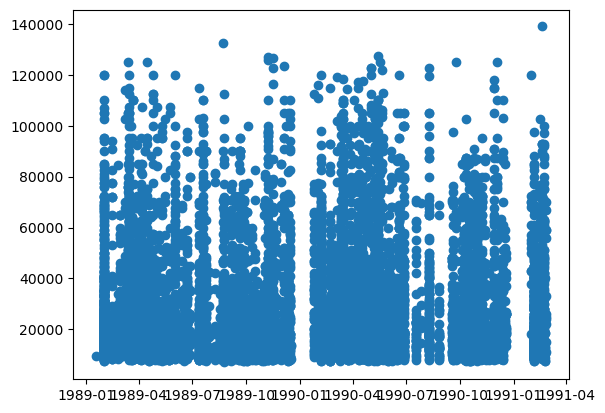

In [72]:
fig,ax = plt.subplots()
ax.scatter(df_temp.saledate[:10000],df_temp.SalePrice[:10000])

In [73]:
df_temp.saledate[:1000]
#df_temp.saledate.dtype
#df_temp.SalePrice.plot.hist()

StatementMeta(, f9c678c8-e03d-4f3b-aab6-8439f50d04bd, 75, Finished, Available)

205615   1989-01-17
274835   1989-01-31
141296   1989-01-31
212552   1989-01-31
62755    1989-01-31
            ...    
54344    1989-03-16
143206   1989-03-16
93144    1989-03-16
86917    1989-03-16
115938   1989-03-16
Name: saledate, Length: 1000, dtype: datetime64[ns]

In [74]:
df_temp.head().T

StatementMeta(, f9c678c8-e03d-4f3b-aab6-8439f50d04bd, 76, Finished, Available)

,205615,274835,141296,212552,62755
SalesID,1646770,1821514,1505138,1671174,1329056
SalePrice,9500.0,14000.0,50000.0,16000.0,22000.0
MachineID,1126363,1194089,1473654,1327630,1336053
ModelID,8434,10150,4139,8591,4089
datasource,132,132,132,132,132
auctioneerID,18.0,99.0,99.0,99.0,99.0
YearMade,1974,1980,1978,1980,1984
MachineHoursCurrentMeter,NaN,NaN,NaN,NaN,NaN
UsageBand,NaN,NaN,NaN,NaN,NaN
saledate,1989-01-17 00:00:00,1989-01-31 00:00:00,1989-01-31 00:00:00,1989-01-31 00:00:00,1989-01-31 00:00:00


Adding more datetime parameters from ``saledate`` column

In [75]:
df_temp['saleYear'] = df_temp.saledate.dt.year
df_temp['saleMonth'] = df_temp.saledate.dt.month
df_temp['saleDay']= df_temp.saledate.dt.day
df_temp['saleDayOfWeek'] = df_temp.saledate.dt.dayofweek
df_temp['saleDayOfYear'] = df_temp.saledate.dt.dayofyear

#df_temp.drop('saledate',axis=1,inplace=True)

StatementMeta(, f9c678c8-e03d-4f3b-aab6-8439f50d04bd, 77, Finished, Available)

In [76]:
df_temp.state.value_counts()
#len(df_temp)

StatementMeta(, f9c678c8-e03d-4f3b-aab6-8439f50d04bd, 78, Finished, Available)

state
Florida           67320
Texas             53110
California        29761
Washington        16222
Georgia           14633
Maryland          13322
Mississippi       13240
Ohio              12369
Illinois          11540
Colorado          11529
New Jersey        11156
North Carolina    10636
Tennessee         10298
Alabama           10292
Pennsylvania      10234
South Carolina     9951
Arizona            9364
New York           8639
Connecticut        8276
Minnesota          7885
Missouri           7178
Nevada             6932
Louisiana          6627
Kentucky           5351
Maine              5096
Indiana            4124
Arkansas           3933
New Mexico         3631
Utah               3046
Unspecified        2801
Wisconsin          2745
New Hampshire      2738
Virginia           2353
Idaho              2025
Oregon             1911
Michigan           1831
Wyoming            1672
Montana            1336
Iowa               1336
Oklahoma           1326
Nebraska            866
West Virgi

# Part 2

#### Converting all data to numbers

In [77]:
def convert_text_columns_to_numbers():
    for label, content in df_temp.items():
        if pd.api.types.is_string_dtype(content):
            df_temp[label] = content.astype('category').cat.as_ordered()


def add_missing_values_to_empty_columns():
    for label, content in df_temp.items():
        if pd.api.types.is_numeric_dtype(content):
            if pd.isnull(content).sum():
                df_temp[label + '_is_missing'] = pd.isnull(content)
                df_temp[label] = content.fillna(content.median()) 


def convert_categorical_values_to_numbers():
    for label, content in df_temp.items():
        if not pd.api.types.is_numeric_dtype(content):
            df_temp[label + '_is_missing'] = pd.isnull(content)
            df_temp[label] = pd.Categorical(content).codes + 1


convert_text_columns_to_numbers()
add_missing_values_to_empty_columns()
convert_categorical_values_to_numbers()

StatementMeta(, f9c678c8-e03d-4f3b-aab6-8439f50d04bd, 79, Finished, Available)

/tmp/ipykernel_5697/4127014508.py:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_temp[label + '_is_missing'] = pd.isnull(content)


Verify if all string columns were converted to numeric

In [78]:
#df_temp.info()
#df_temp.state.cat.categories
#df_temp.state.cat.codes
df_temp.head().T

StatementMeta(, f9c678c8-e03d-4f3b-aab6-8439f50d04bd, 80, Finished, Available)

,205615,274835,141296,212552,62755
SalesID,1646770,1821514,1505138,1671174,1329056
SalePrice,9500.0,14000.0,50000.0,16000.0,22000.0
MachineID,1126363,1194089,1473654,1327630,1336053
ModelID,8434,10150,4139,8591,4089
datasource,132,132,132,132,132
...,...,...,...,...,...
Backhoe_Mounting_is_missing,False,True,False,True,False
Blade_Type_is_missing,False,True,False,True,False
Travel_Controls_is_missing,False,True,False,True,False
Differential_Type_is_missing,True,False,True,False,True


In [79]:
df_temp.to_csv('/lakehouse/default/Files/bulldozer-price-regression/train_temp.csv',index=False)

df_temp = pd.read_csv('/lakehouse/default/Files/bulldozer-price-regression/train_temp.csv',low_memory=False)

StatementMeta(, f9c678c8-e03d-4f3b-aab6-8439f50d04bd, 81, Finished, Available)

In [80]:
df_temp.isnull().sum()

StatementMeta(, f9c678c8-e03d-4f3b-aab6-8439f50d04bd, 82, Finished, Available)

SalesID                         0
SalePrice                       0
MachineID                       0
ModelID                         0
datasource                      0
                               ..
Backhoe_Mounting_is_missing     0
Blade_Type_is_missing           0
Travel_Controls_is_missing      0
Differential_Type_is_missing    0
Steering_Controls_is_missing    0
Length: 105, dtype: int64

#### Split and Training data

In [81]:
np.random.seed(1000)

StatementMeta(, f9c678c8-e03d-4f3b-aab6-8439f50d04bd, 83, Finished, Available)

In [82]:
df_val = df_temp[df_temp['saleYear'] == 2012]
df_train = df_temp[df_temp['saleYear'] != 2012]

X_train, y_train = df_train.drop('SalePrice',axis=1), df_train.SalePrice
X_valid, y_valid = df_val.drop('SalePrice', axis=1), df_val.SalePrice

StatementMeta(, f9c678c8-e03d-4f3b-aab6-8439f50d04bd, 84, Finished, Available)

Having partitioned our dataset into training and testing subsets, we are now poised to construct a machine learning model.

The model will undergo training (pattern discovery) using the training subset.

Subsequently, the testing subset will be employed to evaluate the model (pattern application).

We plan to experiment with three distinct machine learning evaluation:

1. mean_squared_log_error
2. mean_absolute_error
3. r2_score

#### Create a dictionary of evaluation metrics

In [83]:
def rmsle(y_test,y_preds):
    """
    Caculates root mean squared log error between predictions and
    true labels.
    """
    return np.sqrt(mean_squared_log_error(y_test,y_preds))

def show_scores(model):
    train_preds = model.predict(X_train)
    val_preds = model.predict(X_valid)
    scores = {"Training MAE": mean_absolute_error(y_train, train_preds),
              "Valid MAE": mean_absolute_error(y_valid, val_preds),
              "Training RMSLE": rmsle(y_train, train_preds),
              "Valid RMSLE": rmsle(y_valid, val_preds),
              "Training R^2": r2_score(y_train, train_preds),
              "Valid R^2": r2_score(y_valid, val_preds)}
    return scores

StatementMeta(, f9c678c8-e03d-4f3b-aab6-8439f50d04bd, 85, Finished, Available)

In [84]:
%%time
model = RandomForestRegressor(n_jobs=-1, max_samples=1000)
model.fit(X_train,y_train)

StatementMeta(, f9c678c8-e03d-4f3b-aab6-8439f50d04bd, 86, Finished, Available)

2024-05-02:21:58:01,233 WARNING  [tracking_store.py:153] log_inputs not supported


CPU times: user 17 s, sys: 421 ms, total: 17.4 s
Wall time: 12.8 s


RandomForestRegressor(max_samples=1000, n_jobs=-1)

# Part 3

#### Create a baseline by running the models

In [85]:
show_scores(model)

StatementMeta(, f9c678c8-e03d-4f3b-aab6-8439f50d04bd, 87, Finished, Available)

2024-05-02:21:58:14,749 WARNING  [tracking_store.py:153] log_inputs not supported
2024-05-02:21:58:14,966 WARNING  [tracking_store.py:153] log_inputs not supported


{'Training MAE': 7626.366695194763,
 'Valid MAE': 9391.124663440767,
 'Training RMSLE': 0.34115181411916384,
 'Valid RMSLE': 0.38330449632389296,
 'Training R^2': 0.7575406455080388,
 'Valid R^2': 0.7370861915779783}

#### 

#### Hyperparameter optimization using RandomizedSearchCV()

In [86]:
number_of_iteration = 2
cross_fold = 5

hyperparameter_results = {}

StatementMeta(, f9c678c8-e03d-4f3b-aab6-8439f50d04bd, 88, Finished, Available)

In [87]:
# hyperparameter for RandomForestClassifier()
randomforest_grid = {
    'n_estimators': np.arange(10,100,10),
    'max_depth': [None,3, 5, 10],
    
    'min_samples_split': np.arange(2,20,2),
    'min_samples_leaf': np.arange(1,20,2),
    "max_features": [0.5, 1, "sqrt", "auto"],
           "max_samples": [10000]
}

randomforest_regression = RandomizedSearchCV(
                        RandomForestRegressor(n_jobs=-1,random_state=42),
                        param_distributions = randomforest_grid,
                        cv=cross_fold,
                        n_iter=number_of_iteration,
                        verbose=True
                        )
randomforest_regression.fit(X_train, y_train)

StatementMeta(, f9c678c8-e03d-4f3b-aab6-8439f50d04bd, 89, Finished, Available)

Fitting 5 folds for each of 2 candidates, totalling 10 fits


2024-05-02:21:58:25,516 WARNING  [tracking_store.py:153] log_inputs not supported
/home/trusted-service-user/cluster-env/trident_env/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:425: FitFailedWarning: 
5 fits failed out of a total of 10.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/home/trusted-service-user/cluster-env/trident_env/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 732, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/trusted-service-user/cluster-env/trident_env/lib/python3.10/site-packages/mlflow/utils/autologging_utils/safety.py", line 573, in safe_patch_f

/home/trusted-service-user/cluster-env/trident_env/lib/python3.10/site-packages/jupyter_client/session.py:721: UserWarning: Message serialization failed with:
Out of range float values are not JSON compliant
Supporting this message is deprecated in jupyter-client 7, please make sure your message is JSON-compliant
  content = self.pack(content)


RandomizedSearchCV(cv=5,
                   estimator=RandomForestRegressor(n_jobs=-1, random_state=42),
                   n_iter=2,
                   param_distributions={'max_depth': [None, 3, 5, 10],
                                        'max_features': [0.5, 1, 'sqrt',
                                                         'auto'],
                                        'max_samples': [10000],
                                        'min_samples_leaf': array([ 1,  3,  5,  7,  9, 11, 13, 15, 17, 19]),
                                        'min_samples_split': array([ 2,  4,  6,  8, 10, 12, 14, 16, 18]),
                                        'n_estimators': array([10, 20, 30, 40, 50, 60, 70, 80, 90])},
                   verbose=True)

In [88]:
randomforest_regression.best_params_

StatementMeta(, f9c678c8-e03d-4f3b-aab6-8439f50d04bd, 90, Finished, Available)

{'n_estimators': 40,
 'min_samples_split': 14,
 'min_samples_leaf': 15,
 'max_samples': 10000,
 'max_features': 'sqrt',
 'max_depth': 5}

In [89]:
show_scores(randomforest_regression)

StatementMeta(, f9c678c8-e03d-4f3b-aab6-8439f50d04bd, 91, Finished, Available)

2024-05-02:21:58:42,874 WARNING  [tracking_store.py:153] log_inputs not supported
2024-05-02:21:58:43,50 WARNING  [tracking_store.py:153] log_inputs not supported


{'Training MAE': 11866.913464337182,
 'Valid MAE': 13670.017702042036,
 'Training RMSLE': 0.5102006130087475,
 'Valid RMSLE': 0.5199102966591331,
 'Training R^2': 0.4758974560986946,
 'Valid R^2': 0.4799583830269226}

In [90]:
randomforest_regression.best_params_

StatementMeta(, f9c678c8-e03d-4f3b-aab6-8439f50d04bd, 92, Finished, Available)

{'n_estimators': 40,
 'min_samples_split': 14,
 'min_samples_leaf': 15,
 'max_samples': 10000,
 'max_features': 'sqrt',
 'max_depth': 5}